In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

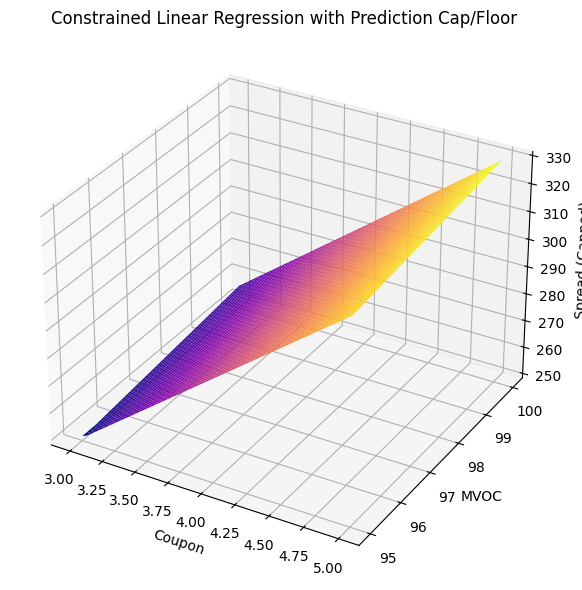

In [3]:
from scipy.optimize import minimize

# Example data
df = pd.DataFrame({
    "coupon": [3.0, 3.5, 4.0, 4.5, 5.0],
    "mvoc":   [95, 97, 98, 99, 100],
    "spread": [250, 270, 290, 310, 330]
})

X = df[["coupon", "mvoc"]].values
y = df["spread"].values

# Add intercept
X_design = np.hstack([np.ones((X.shape[0], 1)), X])  # [1, coupon, mvoc]

# Objective function: minimize squared error
def loss_fn(beta):
    pred = X_design @ beta
    return np.mean((pred - y) ** 2)

# Initial guess
beta0 = np.array([0, 1, 1])

# Constraints: beta[1] >= 0, beta[2] >= 0
bounds = [(None, None), (0, None), (0, None)]

# Fit the model
result = minimize(loss_fn, beta0, bounds=bounds)

# Fitted parameters
beta_fit = result.x

# Predict function with cap and floor
def predict_constrained(X_new, beta, floor=250, cap=400):
    X_new_design = np.hstack([np.ones((X_new.shape[0], 1)), X_new])
    preds = X_new_design @ beta
    return np.clip(preds, floor, cap)

# Generate surface
coupon_grid = np.linspace(3.0, 5.0, 50)
mvoc_grid = np.linspace(95, 100, 50)
C, M = np.meshgrid(coupon_grid, mvoc_grid)
X_new = np.column_stack([C.ravel(), M.ravel()])
S = predict_constrained(X_new, beta_fit, floor=250, cap=400).reshape(C.shape)

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(C, M, S, cmap="plasma", edgecolor="none")
ax.set_xlabel("Coupon")
ax.set_ylabel("MVOC")
ax.set_zlabel("Spread (Capped)")
ax.set_title("Constrained Linear Regression with Prediction Cap/Floor")
plt.tight_layout()
plt.show()


In [7]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


            Model        R2          RMSE
0  Multiplicative  0.574791  74785.827756
1          Linear  0.552726  76701.676485
2   Decision Tree  0.611384  71495.433522


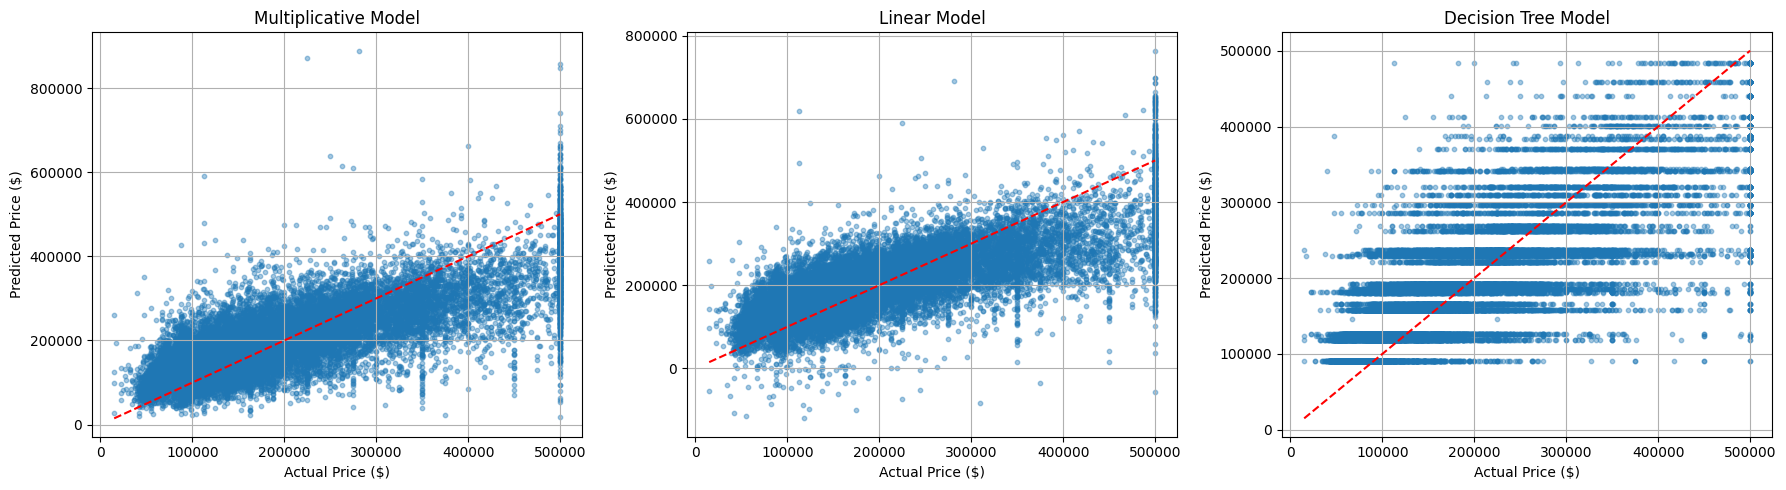

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit

# Load California housing data
data = fetch_california_housing(as_frame=True)
df = data.frame

# Select relevant features and target
features = ['MedInc', 'AveRooms', 'AveOccup']
X = df[features]
y = df['MedHouseVal'] * 100000  # Convert to dollars

# Remove outliers for clearer modeling
mask = (X['MedInc'] < 15) & (X['AveRooms'] < 20) & (X['AveOccup'] < 10)
X = X[mask]
y = y[mask]

# Multiplicative model: y = a * x1^b1 * x2^b2 * x3^b3
def multiplicative_model(X_data, a, b1, b2, b3):
    x1, x2, x3 = X_data
    return a * x1**b1 * x2**b2 * x3**b3

# Fit multiplicative model using curve_fit
X_data = np.vstack([X[col].values for col in features])
params, _ = curve_fit(multiplicative_model, X_data, y, p0=[1, 1, 1, 1])
y_pred_mul = multiplicative_model(X_data, *params)

# Fit linear regression
lin_reg = LinearRegression().fit(X, y)
y_pred_lin = lin_reg.predict(X)

# Fit decision tree
tree = DecisionTreeRegressor(max_depth=5, random_state=0)
tree.fit(X, y)
y_pred_tree = tree.predict(X)

# Evaluate model performance
def evaluate(y_true, y_pred):
    return r2_score(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))

results = {
    "Model": ["Multiplicative", "Linear", "Decision Tree"],
    "R2": [
        evaluate(y, y_pred_mul)[0],
        evaluate(y, y_pred_lin)[0],
        evaluate(y, y_pred_tree)[0]
    ],
    "RMSE": [
        evaluate(y, y_pred_mul)[1],
        evaluate(y, y_pred_lin)[1],
        evaluate(y, y_pred_tree)[1]
    ]
}

print(pd.DataFrame(results))

# Plot actual vs predicted
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
models = ["Multiplicative", "Linear", "Decision Tree"]
preds = [y_pred_mul, y_pred_lin, y_pred_tree]

for ax, model, pred in zip(axs, models, preds):
    ax.scatter(y, pred, alpha=0.4, s=10)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    ax.set_title(f"{model} Model")
    ax.set_xlabel("Actual Price ($)")
    ax.set_ylabel("Predicted Price ($)")
    ax.grid(True)

plt.tight_layout()
plt.show()


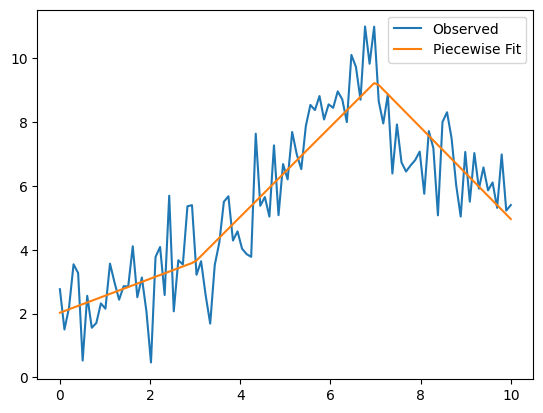

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrix

# Simulated data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.piecewise(x, [x < 3, (x >= 3) & (x < 7), x >= 7], [lambda x: x + 1, lambda x: 2 * x - 3, lambda x: -x + 15])
y += np.random.normal(scale=1.0, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# Create piecewise linear terms using splines
x_spline = dmatrix("bs(x, knots=(3,7), degree=1, include_intercept=False)", data=df, return_type='dataframe')

# Fit linear model
model = sm.OLS(df['y'], x_spline).fit()

# Predict
df['y_pred'] = model.predict(x_spline)

# Plot
import matplotlib.pyplot as plt
plt.plot(df['x'], df['y'], label='Observed')
plt.plot(df['x'], df['y_pred'], label='Piecewise Fit')
plt.legend()
plt.show()


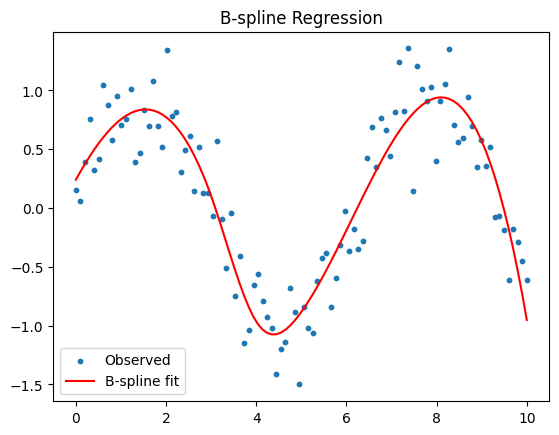

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix

# Generate data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(scale=0.3, size=len(x))
df = pd.DataFrame({'x': x, 'y': y})

# B-spline basis with degree=3 and 3 internal knots
spline_basis = dmatrix("bs(x, knots=(3, 4, 5), degree=3, include_intercept=True)", data=df)

# Fit a linear model to the B-spline basis
import statsmodels.api as sm
model = sm.OLS(df['y'], spline_basis).fit()
df['y_hat'] = model.predict(spline_basis)

# Plot
plt.scatter(df['x'], df['y'], label='Observed', s=10)
plt.plot(df['x'], df['y_hat'], label='B-spline fit', color='red')
plt.legend()
plt.title('B-spline Regression')
plt.show()


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
import statsmodels.api as sm

# Generate synthetic 2D data
np.random.seed(42)
x = np.random.uniform(0, 10, 200)
y = np.random.uniform(0, 10, 200)
z = np.piecewise(x, [x < 5, x >= 5], [lambda x: x, lambda x: 2*x - 5]) + \
    np.piecewise(y, [y < 5, y >= 5], [lambda y: y, lambda y: -y + 10]) + \
    np.random.normal(0, 0.5, 200)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})


In [2]:
# Create piecewise linear (degree=1) tensor spline basis
X_spline = dmatrix("te(bs(x, df=6, degree=1), bs(y, df=6, degree=1))", data=df, return_type='dataframe')

# Fit linear model
model = sm.OLS(df['z'], X_spline).fit()
df['z_hat'] = model.predict(X_spline)


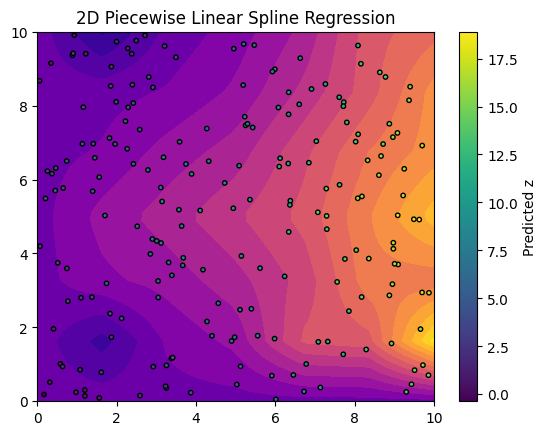

In [3]:
# Predict on a grid
x_grid = np.linspace(0, 10, 50)
y_grid = np.linspace(0, 10, 50)
Xg, Yg = np.meshgrid(x_grid, y_grid)
grid_df = pd.DataFrame({'x': Xg.ravel(), 'y': Yg.ravel()})
Xg_spline = dmatrix("te(bs(x, df=6, degree=1), bs(y, df=6, degree=1))", data=grid_df, return_type='dataframe')
grid_df['z_hat'] = model.predict(Xg_spline)

# Plot the surface
plt.contourf(Xg, Yg, grid_df['z_hat'].values.reshape(50, 50), levels=20, cmap='plasma')
plt.scatter(x, y, c=z, edgecolor='k', s=10)
plt.colorbar(label='Predicted z')
plt.title("2D Piecewise Linear Spline Regression")
plt.show()


In [4]:
%matplotlib notebook


In [5]:
from mpl_toolkits.mplot3d import Axes3D

# 1. Generate prediction grid and predicted z_hat
x_grid = np.linspace(0, 10, 50)
y_grid = np.linspace(0, 10, 50)
Xg, Yg = np.meshgrid(x_grid, y_grid)
grid_df = pd.DataFrame({'x': Xg.ravel(), 'y': Yg.ravel()})
Xg_spline = dmatrix("te(bs(x, df=6, degree=1), bs(y, df=6, degree=1))", data=grid_df, return_type='dataframe')
grid_df['z_hat'] = model.predict(Xg_spline)

# 2. Create the 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 3. Plot the spline surface
ax.plot_surface(Xg, Yg, grid_df['z_hat'].values.reshape(50, 50), alpha=0.7, cmap='plasma', edgecolor='none')

# 4. Scatter the original data points
ax.scatter(df['x'], df['y'], df['z'], c='black', s=20, label='Observed', alpha=0.8)

# 5. Axis labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z / z_hat')
ax.set_title('3D View: 2D Piecewise Linear Spline Fit + Observed Data')


plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [8]:
import plotly.graph_objects as go

# Prepare data
X_plot = Xg
Y_plot = Yg
Z_plot = grid_df['z_hat'].values.reshape(Xg.shape)

# Create 3D surface
fig = go.Figure()

fig.add_trace(go.Surface(
    x=X_plot, y=Y_plot, z=Z_plot,
    colorscale='Plasma', opacity=0.7,
    name='Fitted Surface'
))

# Add observed data points
fig.add_trace(go.Scatter3d(
    x=df['x'], y=df['y'], z=df['z'],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Observed Data'
))

fig.update_layout(
    title="3D Spline Fit + Data",
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='z',
    ),
    width=800,
    height=600
)

fig.show()
